In [1]:
import os
import sys
import numpy as np

import scipy.special as sp

import matplotlib
import matplotlib.pyplot as plt
 
#in order to find where the tests are located
sys.path.append('sp800_22_tests')

data = []

In [2]:
# determine if we are using Windows or Linux filing conventions and assign root folders
if sys.platform == 'win32':
    SCAPA_ROOT = os.path.join('Z:', os.sep, 'group')
    ORKNEY_ROOT = os.path.join('U:', os.sep)
else:
    SCAPA_ROOT = '/mnt/scapa4'
    ORKNEY_ROOT  ='/mnt/orkney1'

ORKNEY_TEAM = os.path.join(ORKNEY_ROOT, 'Clusters')
ORKNEY_PROJECT = os.path.join(ORKNEY_TEAM, 'RandomXtl')
ORKNEY_MASKRCNN = os.path.join(ORKNEY_PROJECT, 'MaskRCNN')
ORKNEY_DETECTED = os.path.join(ORKNEY_MASKRCNN, 'detected')
ORKNEY_TRAINING = os.path.join(ORKNEY_MASKRCNN, 'training')
ORKNEY_DATASETS = os.path.join(ORKNEY_TRAINING, 'datasets')
ORKNEY_LOGS = os.path.join(ORKNEY_TRAINING, 'logs')

ORKNEY_IMAGES = os.path.join(ORKNEY_PROJECT, 'images')
ORKNEY_RAW_IMGS = os.path.join(ORKNEY_IMAGES, 'raw_images')
ORKNEY_PART_IMGS = os.path.join(ORKNEY_IMAGES, 'partitioned')

ORKNEY_CV = os.path.join(ORKNEY_PROJECT, 'computer_vision')
ORKNEY_VIALS = os.path.join(ORKNEY_CV, 'vials')

ORKNEY_RANDOM = os.path.join(ORKNEY_PROJECT, 'random numbers')


IMG_EXTS = ['.img', '.bmp', '.tiff', '.jpg', '.png']

data = []
strings = []

def lin2win(filepath):
    return filepath.replace('/mnt/scapa4', 'Z:').replace('/mnt/orkney1', 'U:').replace('/', '\\')

def win2lin(filepath):
    return filepath.replace('Z:', '/mnt/scapa4' ).replace('U:', '/mnt/orkney1').replace('\\', '/')

In [3]:
def read_bits_from_ascii_file(filepath):
    # obtains all integers from an ascii file and puts them into a list
    # returns list of integers
    bitstring = ''
    for row in open(filepath, 'r').readlines():
        bitstring += row.rstrip('\n').strip()
    bitlist = [int(i) for i in bitstring]
    return bitlist


def read_binary_expansion_file(filepath):

    with open(filepath, 'r') as f:
        string = f.read()
    string = string.replace(' ', "")
    string = string.replace('\r', "")
    string = string.replace('\n', "")
    string = [int(i) for i in list(string)]
    
    return string

def get_chunks(bitlist, number_of_chunks=None, chunk_length=None):
    # partitions long bitstring into several small chunks of set length
    # returns list of list of integers
    print('chunking...')
    # returns original string (in a list) if no parameters are set
    if not number_of_chunks and not chunk_length:
        number_of_chunks, chunk_length = 1, len(bits)
        
    # calculates chunk_length if only number_of_chunks set
    elif number_of_chunks and not chunk_length:
        chunk_length = int(len(bitlist) / number_of_chunks)
    
    # calculates number_of_chunks if only chunk_length set
    elif not number_of_chunks and chunk_length:
        number_of_chunks = int(len(bitlist) / chunk_length)
    
    # generates specified number of chunks with specified length
    chunks = [bitlist[idx*chunk_length:(idx+1)*chunk_length] for idx in range(number_of_chunks)]
    print('got chunks.')
    return chunks

def deskew(bits):
    n = len(bits)
    deskewed = []
    for idx in range(int(n/2)):
        pairs = bits[idx*2:(idx+1)*2]
        if pairs[0] == pairs[1]:
            pass
        elif pairs[0] == 1:
            deskewed.append(1)
        else:
            deskewed.append(0)
    return deskewed
        

In [4]:
def run_chunks(chunks):
    # assess each chunk in a loop
    # results are a dictionary with dict[testname] = [p-values] for all testnames
    chunk_results = list()

    print('Number of chunks: {}, size of chunks: {}'.format(len(chunks), len(chunks[0])))
    len_chunks = len(chunks)
    for idx, chunk in enumerate(chunks):
        sys.stdout.write('\rChunk {} / {}'.format(idx+1, len(chunks)))
        chunk_results.append(run_testlist(idx, len_chunks, chunk))
    return chunk_results

def run_testlist(idx, len_chunks, bits):
    
    results = list()
    for testname in testlist:
        m = __import__ ("sp800_22_"+testname)
        func = getattr(m,testname) 
        (success,p,plist) = func(bits)

        summary_name = testname
        if success:
            summary_result = "PASS"
        else:
            summary_result = "FAIL"
        
        if p != None:
            summary_p = str(p)
        
        results.append((summary_name,summary_p, summary_result))
    return results



In [5]:
def collate_results(data):
    # create results dictionary where dict[testname] = p-value
    res_dict = {}
    for test in testlist:
        res_dict[test] = []
    for chunk in data:       
        for test in chunk:
            res_dict[test[0]].append(float(test[1]))
    return res_dict 

def calc_stats(data):
    # generate 11 bin edges -> 10 bins between 0 and 1
    bins = np.linspace(0,1,11)
    stats = {}
    # create stats dictionary where dict[testname] = dictionary of test statistics for each testname
    for test in data:
        stats[test] = {}
    
    for test in data:
        applicable = [i for i in data[test] if i > 0]
        
        hist, edges = np.histogram(applicable, bins)
        stats[test]['hist'] = hist
        stats[test]['hist axis'] = np.linspace(0.05, 0.95, 10)
        stats[test]['uniformity'] = calc_uniformity(hist)
        if len(applicable) > 0:
            stats[test]['pass rate'] = sum([1 for p in applicable if p > 0.01])/len(applicable)
            stats[test]['pass window'] = calc_passwindow(applicable)
        else: 
            stats[test]['pass rate'] = 0
            stats[test]['pass window'] = [0,1]
       
    return stats

def calc_uniformity(hist):
    chi_sq = sum([(i-(sum(hist)/10))**2/(sum(hist)/10) for i in hist])
    p_value = 1-sp.gammainc(9/2, chi_sq/2)
    return p_value

def calc_passwindow(p_values):

        p_hat = 0.99
        pass_window = 3*np.sqrt((p_hat*(1-p_hat)/len(p_values)))

        pass_min = p_hat - pass_window
        pass_max = p_hat + pass_window
        return pass_min, pass_max


In [6]:
def run_exp(exp_path, rxn_range):
    start, end = rxn_range
    path_parts =exp_path.split('/')
    cmpd, exp = path_parts[-2:]
    exp_dir = os.path.join(ORKNEY_RANDOM, 'microstates mod', cmpd, exp)
    rxns = sorted([i for i in os.listdir(exp_dir) if 'reaction' in i.lower()])
    all_strings = []
    big_string = ''
    for rxn in rxns[start: end]:     
        rxn_path = os.path.join(exp_dir, rxn)
        string = run_rxn(rxn_path)
        big_string += string
        all_strings.append(string)
    return big_string, all_strings

def run_rxn(rxn_path):

    image_names = sorted([i for i in os.listdir(rxn_path)])

    for name in image_names:    
        
        string_path= os.path.join(rxn_path, name, 'strings', 'all.txt')
        sys.stdout.write('\r{}'.format(string_path))      
        string = ''.join([str(i) for i in read_bits_from_ascii_file(string_path)])
    return string


In [7]:
Cu1 = {'path': '/mnt/orkney1/Chemobot/crystalbot_imgs/CuSO4/180906a',
     'ver': '',
     'partitioning':[6,6,0.2],
     'image': [-2,-1],
     'reactions':[0,49]}
Cu2 = {'path': '/mnt/orkney1/Chemobot/crystalbot_imgs/CuSO4/180907d',
     'ver': '',
     'partitioning':[6,6,0.2],
     'image': [31,32],
     'reactions':[0,47]}
W1 = {'path': '/mnt/orkney1/Chemobot/crystalbot_imgs/W19/20180214-1',
     'ver': '',
     'partitioning':[4,4,0.2],
     'image': [78,79],
     'reactions':[0,99]}
W2 = {'path': '/mnt/orkney1/Chemobot/crystalbot_imgs/W19/20180214-0',
     'ver': '',
     'partitioning':[6,6,0.2],
     'image': [20,21],
     'reactions':[0,99]}
Co1 = {'path': '/mnt/orkney1/Chemobot/crystalbot_imgs/Co4/20180216-0',
     'ver': 'v2',
     'partitioning':[6,6,0.2],
     'image': [70,71],
     'reactions':[0,99]}
Co2 = {'path': '/mnt/orkney1/Chemobot/crystalbot_imgs/Co4/20180219-0',
     'ver': 'v2',
     'partitioning':[6,6,0.2],
     'image': [51,52],
     'reactions':[0,99]}

In [8]:


alltests = [
        'monobit_test',   
        'frequency_within_block_test',
        'runs_test',
        'longest_run_ones_in_a_block_test',
        'binary_matrix_rank_test',
        'dft_test',
        'non_overlapping_template_matching_test',
        'overlapping_template_matching_test',
        'maurers_universal_test',
        'linear_complexity_test',
        'serial_test',
        'approximate_entropy_test',
        'cumulative_sums_test',
        'random_excursion_test',
        'random_excursion_variant_test',
        ]              

#short tests
fasttests = [        
        'monobit_test',   # very fast
        'frequency_within_block_test',    # very fast
#         'runs_test',     # medium
        'longest_run_ones_in_a_block_test', # very fast
#         'binary_matrix_rank_test',    # slow
#         'dft_test',    # medium
#         'non_overlapping_template_matching_test',   # medium
        'overlapping_template_matching_test',   # fast
#         'maurers_universal_test',      # slow
#         'linear_complexity_test',       # very slow
#         'serial_test',      # very slow
#         'approximate_entropy_test',    # very slow
#         'cumulative_sums_test',       # slow
#         'random_excursion_test',     # very slow
        'random_excursion_variant_test', # fast
              ]

#medium length tests
mediumtests = [        
        'monobit_test',
        'frequency_within_block_test',
        'runs_test',
        'longest_run_ones_in_a_block_test',
#         'binary_matrix_rank_test',
        'dft_test',
        'non_overlapping_template_matching_test',
        'overlapping_template_matching_test',
#         'maurers_universal_test',
#         'linear_complexity_test',
#         'serial_test',
#         'approximate_entropy_test',
#         'cumulative_sums_test',
#         'random_excursion_test',
        'random_excursion_variant_test',
              ]
testlist = alltests

In [9]:
EXPS = [Cu1]

In [10]:
exp_idx = -1
exp_path = EXPS[exp_idx]['path']
print(EXPS[exp_idx]['path'])
rxn_range = [0,100]
exp_string, rxn_strings = run_exp(exp_path, rxn_range)
strings.append({'exp string': exp_string, 'exp':EXPS[exp_idx], 'rxn strings':rxn_strings})
print('\n', len(exp_string))

/mnt/orkney1/Chemobot/crystalbot_imgs/CuSO4/180906a
U:\Clusters\RandomXtl\random numbers\microstates mod\CuSO4\180906a\reaction_49\027\strings\all.txt
 224075776


In [12]:
number_of_bits = -1
print(EXPS[exp_idx]['path'])
bits= strings[-1]['exp string'][:number_of_bits]
bits = [int(i) for i in bits]
chunk_n = 200
chunks = get_chunks(bits, number_of_chunks = chunk_n, chunk_length=None)
chunks_data = run_chunks(chunks)
results = collate_results(chunks_data)
stats = calc_stats(results)
result = {'stats': stats,'results': results, 'path':exp_path, 'chunks':chunk_n}
data.append(result)

/mnt/orkney1/Chemobot/crystalbot_imgs/CuSO4/180906a
chunking...
got chunks.
Number of chunks: 200, size of chunks: 1120378
Chunk 200 / 200

In [19]:
print(data[-1]['path'])

compound = 'CuSO4-180906a'

data_to_write = data[-1]
print(type(data_to_write))
import pickle as pkl
description = 'CuSO4-180906a-microstates mod'

filename = '.\\data\\{}.p'.format(description)
pkl.dump(data_to_write, open(filename, 'wb'))

/mnt/orkney1/Chemobot/crystalbot_imgs/CuSO4/180906a
<class 'dict'>


/mnt/orkney1/Chemobot/crystalbot_imgs/CuSO4/180906a


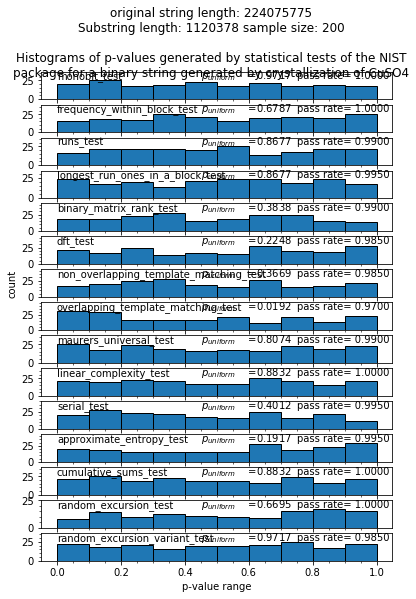

In [20]:
data_idx = -1
print(EXPS[exp_idx]['path'])
compound = 'CuSO4'
fig, axs = plt.subplots(len(testlist), sharex='col', figsize=(6.3,9))
t1 = 'original string length: {}\n'.format(len(bits))
t2 = 'Substring length: {} sample size: {}\n\n'.format(len(chunks[0]), len(chunks))
t3 = 'Histograms of p-values generated by statistical tests of the NIST\n'
t4 = 'package for a binary string generated by crystallization of {}'.format(compound)
title = t1+t2+t3+t4
fig.suptitle(title)

for idx, test in enumerate(testlist):
    sys.stdout.write('\rplotting test {} ({}/{})'.format(test, idx, len(testlist)))
    this_result = data[data_idx]
    these_stats = this_result['stats']
    this_hist = these_stats[test]['hist']
    this_axis = these_stats[test]['hist axis']
    axs[idx].bar(this_axis, this_hist, width=0.1, edgecolor='k' )
    
    ymax = int(max(this_hist) *1.5)
    axs[idx].set_ylim(ymin=0, ymax = ymax)
    text_height = (ymax*0.8+max(this_hist))/2
    if test == 'NonOverlappingTemplateMatching':
        fontsize = 8
    else:
        fontsize = 10
    axs[idx].text(0,text_height, test, fontsize=fontsize)
    axs[idx].text(0.45,text_height,'{}'.format(r'$p_{uniform}$'+'    ={0:.4f}'.format(these_stats[test]['uniformity'])))
    axs[idx].text(0.75, text_height,'pass rate= {0:.4f}'.format(these_stats[test]['pass rate']))
    axs[idx].minorticks_on()

    if idx == int(len(testlist)/2) -1:
        axs[idx].set_ylabel('count', rotation=90)
axs[idx].set_xlabel('p-value range')

plt.savefig('{}-test1_2.svg'.format(compound))
plt.savefig('{}-test1_2.png'.format(compound))
plt.show()

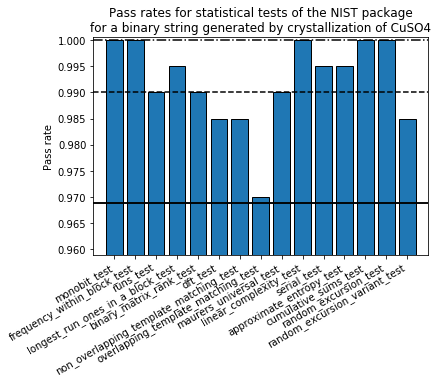

In [21]:
xs = []
ys = []

for test in testlist:
    xs.append(test)
    ys.append(stats[test]['pass rate'])

t1 = 'Pass rates for statistical tests of the NIST package\n'
t2 = 'for a binary string generated by crystallization of {}'.format(compound)
plt.title(t1+t2)
plt.bar(xs, ys,width=0.8,edgecolor='k')

plt.hlines([1], [-1],[len(testlist)],  linestyle='-.')
plt.hlines([stats[test]['pass window'][0]], [-1],[len(testlist)],  linestyle='-')
plt.hlines([0.99], [-1],[len(testlist)],  linestyle='--')
plt.hlines([stats[test]['pass window'][0]], [-1],[len(testlist)],  linestyle='-')
plt.xticks(rotation=30, ha='right')
plt.xlim(-1,len(testlist))
y_max = (stats[test]['pass window'][1] + 0.99) / 2
y_min = (stats[test]['pass window'][0]+0.99)-1
plt.ylim(y_min, y_max)
plt.ylabel('Pass rate')
plt.savefig('{} - second order.svg'.format(compound))
plt.show()

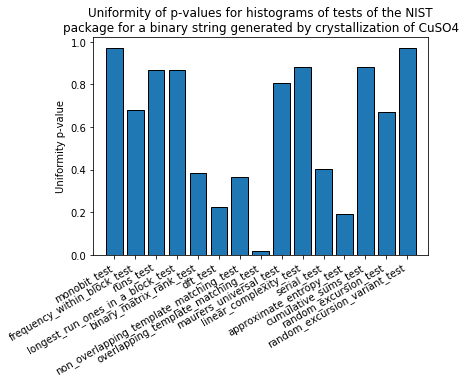

In [22]:
xs = []
ys = []

for test in testlist:
    xs.append(test)
    ys.append(stats[test]['uniformity'])

t1 = 'Uniformity of p-values for histograms of tests of the NIST\n'
t2 = 'package for a binary string generated by crystallization of {}'.format(compound)

plt.title(t1+t2)
plt.bar(xs, ys, width=0.8, edgecolor='k')
plt.xticks(rotation=30, ha='right')
plt.xlim(-1,len(testlist))
plt.ylabel('Uniformity p-value')
plt.savefig('{} - third order.svg'.format(compound))
plt.show()